# Plot ELG chains
This jupyter notebook contains some code to make plots of the bestfits and contours for the abacus cubic ELG fits to both the mock mean and individual realisations.

In [6]:
# Import some necessary modules
import os
import sys
import pickle
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer     

sys.path.append("../Barry/")     # Change this so that it points to where you have Barry installed

from barry.samplers import DynestySampler
from barry.config import setup
from barry.models import PowerBeutler2017, CorrBeutler2017
from barry.datasets.dataset_power_spectrum import PowerSpectrum_DESI_KP4
from barry.datasets.dataset_correlation_function import CorrelationFunction_DESI_KP4
from barry.fitter import Fitter
from barry.models.model import Correction # class for applying corrections to the likelihood function 
from barry.utils import weighted_avg_and_cov # function for getting avg and covariance 

# Read in the fitter class to get all the info on the fit
pfn = "../plots/desi_kp4_abacus_cubic_ELG/output/desi_kp4_abacus_cubic_ELG.fitter.pkl"
#pfn = "plots/desi_kp4_abacus_cubic_ELG/output/desi_kp4_abacus_cubic_ELG.fitter.pkl"
with open(pfn, 'rb') as pickle_file:
    fitter = pickle.load(pickle_file)

FileNotFoundError: [Errno 2] No such file or directory: '../plots/desi_kp4_abacus_cubic_ELG/output/desi_kp4_abacus_cubic_ELG.fitter.pkl'

This code segment reads in the chains, plots the bestfit model vs. data and prepares stuff for contour plots and summary files

In [4]:
logging.info("Creating plots")

fitname = []
datanames = ["CV_Xi_Prerecon", "CV_Xi_Recon", "CV_Pk_Prerecon", "CV_Pk_Recon"]
c = [ChainConsumer(), ChainConsumer(), ChainConsumer(), ChainConsumer()]

# Loop over all the chains
stats = {k: [] for k in datanames}
output = {k: [] for k in datanames}
for posterior, weight, chain, evidence, model, data, extra in fitter.load():

    # Get the realisation number and redshift bin
    if "CV" not in extra["name"]:
        continue
    recon_bin = 0 if "Prerecon" in extra["name"] else 1
    data_bin = 0 if "Xi" in extra["name"] else 1
    realisation = str(extra["name"].split()[-1]) if "realisation" in extra["name"] else "mean"
    chain_bin = int(2.0 * data_bin + recon_bin)
    print(extra["name"], recon_bin, data_bin, chain_bin, realisation)
    
    print(model.get_labels(), chain.shape)
    # Store the chain in a dictionary with parameter names
    df = pd.DataFrame(chain, columns=model.get_labels())

    print(df)
    
    exit()
    # Compute alpha_par and alpha_perp for each point in the chain
    alpha_par, alpha_perp = model.get_alphas(df["$\\alpha$"].to_numpy(), df["$\\epsilon$"].to_numpy())
    df["$\\alpha_\\parallel$"] = alpha_par
    df["$\\alpha_\\perp$"] = alpha_perp
                                                        
    # Get the MAP (maximum a posteriori) point and set the model up at this point
    model.set_data(data)
    r_s = model.camb.get_data()["r_s"]
    max_post = posterior.argmax()
    params = df.loc[max_post]
    params_dict = model.get_param_dict(chain[max_post])
    for name, val in params_dict.items():
        model.set_default(name, val)

    # Get some useful properties of the fit, and plot the MAP model against the data if it's the mock mean or realisation 10 (chosen randomly!)
    display = True if realisation == "mean" or realisation == "10" else False
    new_chi_squared, dof, bband, mods, smooths = model.plot(params_dict, display=display)

    # Add the chain or MAP to the Chainconsumer plots
    extra.pop("realisation", None)
    if realisation == "mean":
        c[chain_bin].add_chain(df, weights=weight, **extra, plot_contour=True, plot_point=False, show_as_1d_prior=False)
    else:
        c[chain_bin].add_marker(params, **extra, marker_size=80)

    # Compute some summary statistics and add them to a dictionary
    mean, cov = weighted_avg_and_cov(
        df[
            [
                "$\\alpha_\\parallel$",
                "$\\alpha_\\perp$",
                "$\\Sigma_{nl,||}$",
                "$\\Sigma_{nl,\\perp}$",
            ]
        ],
        weight,
        axis=0,
    )

    corr = cov[1, 0] / np.sqrt(cov[0, 0] * cov[1, 1])
    stats[datanames[chain_bin]].append(
        [mean[0], mean[1], np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1]), corr, new_chi_squared, mean[2], mean[3]]
    )
    
    output[datanames[chain_bin]].append(
        f"{realisation:s}, {mean[0]:6.4f}, {mean[1]:6.4f}, {mean[2]:6.4f}, {mean[3]:6.4f}, {np.sqrt(cov[0, 0]):6.4f}, {np.sqrt(cov[1, 1]):6.4f}, {corr:7.3f}, {r_s:7.3f}, {new_chi_squared:7.3f}, {dof:4d}"
    )

DESI KP4 Abacus CubicBox CV Pk ELG Prerecon mock mean 0 1 2 mean
['$\\Omega_m$', '$N_{\\mathrm{eff}}$', '$\\alpha$', '$\\epsilon$', '$\\Sigma_s$', '$\\beta$', '$\\Sigma_{nl,||}$', '$\\Sigma_{nl,\\perp}$'] (3186, 6)


ValueError: Shape of passed values is (3186, 6), indices imply (3186, 8)

Plot the contour plots and output the summary statistics

CV_Xi_Prerecon


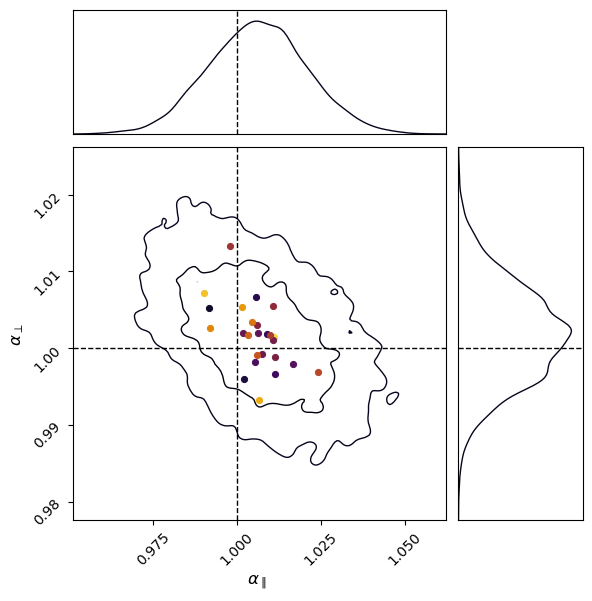

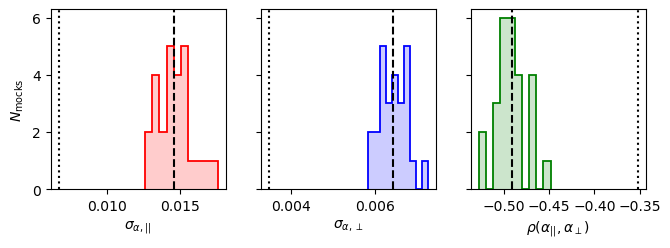

CV_Xi_Recon


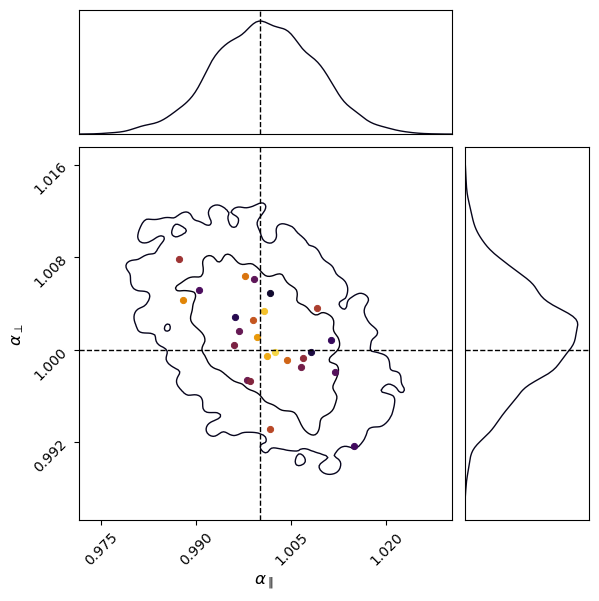

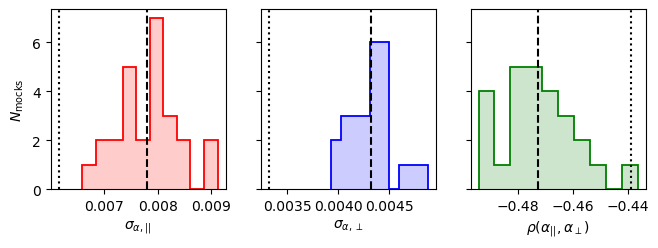

CV_Pk_Prerecon


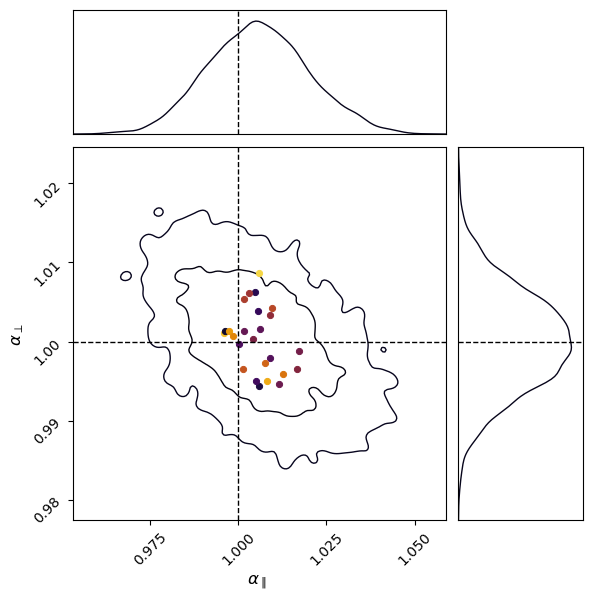

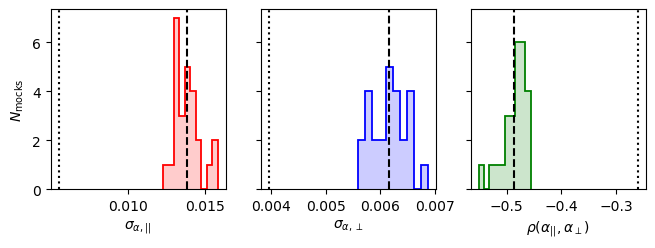

CV_Pk_Recon


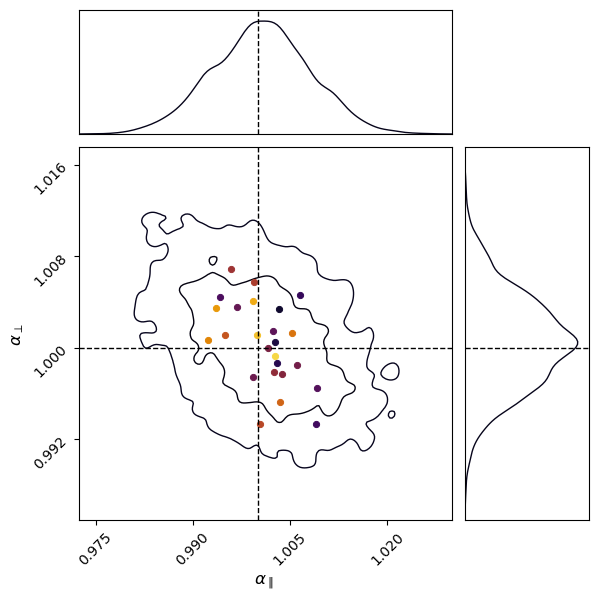

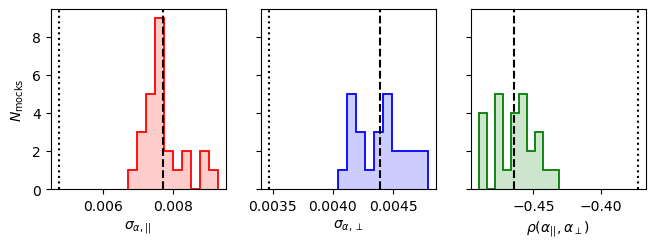

In [5]:
def plot_errors(stats):

    nstats = len(stats)
    means = np.mean(stats, axis=0)
    covs = np.cov(stats, rowvar=False)
    corr = covs[0, 1] / np.sqrt(covs[0, 0] * covs[1, 1])

    labels = [r"$\sigma_{\alpha,||}$", r"$\sigma_{\alpha,\perp}$", r"$\rho(\alpha_{||},\alpha_{\perp})$"]
    colors = ["r", "b", "g"]
    fig, axes = plt.subplots(figsize=(7, 2), nrows=1, ncols=3, sharey=True, squeeze=False)
    plt.subplots_adjust(left=0.1, top=0.95, bottom=0.05, right=0.95, hspace=0.3)
    for ax, vals, avgs, stds, l, c in zip(
        axes.T, np.array(stats).T[2:5], means[2:5], [np.sqrt(covs[0, 0]), np.sqrt(covs[1, 1]), corr], labels, colors
    ):

        ax[0].hist(vals, 10, color=c, histtype="stepfilled", alpha=0.2, density=False, zorder=0)
        ax[0].hist(vals, 10, color=c, histtype="step", alpha=1.0, lw=1.3, density=False, zorder=1)
        ax[0].axvline(avgs, color="k", ls="--", zorder=2)
        ax[0].axvline(stds, color="k", ls=":", zorder=2)
        ax[0].set_xlabel(l)

    axes[0, 0].set_ylabel(r"$N_{\mathrm{mocks}}$")

    plt.show()

    return nstats, means, covs, corr

truth = {"$\\alpha$": 1.0, "$\\epsilon$": 0, "$\\alpha_\\perp$": 1.0, "$\\alpha_\\parallel$": 1.0}
for chain_bin in range(len(c)):
    print(datanames[chain_bin])
    c[chain_bin].plotter.plot(
        truth=truth,
        parameters=["$\\alpha_\\parallel$", "$\\alpha_\\perp$"],
        legend=False,
        display=True,
        figsize=(6,6)
    )

    # Plot histograms of the errors and r_off
    nstats, means, covs, corr = plot_errors(stats[datanames[chain_bin]])
    
    # Save all the numbers to a file
    with open("plots/desi_kp4_abacus_cubic_ELG/output/Barry_fit_" + datanames[chain_bin] + ".txt", "w") as f:
        f.write(
            "# Realisation, alpha_par, alpha_perp, Sigma_nl_par, Sigma_nl_perp, sigma_alpha_par, sigma_alpha_perp, corr_alpha_par_perp, rd_of_template, bf_chi2, dof\n"
        )
        for l in output[datanames[chain_bin]]:
            f.write(l + "\n")

        # And now the average of all the individual realisations
        f.write("# ---------------------------------------------------\n")
        f.write(
            "# <alpha_par>, <alpha_perp>, <Sigma_nl_par>, <Sigma_nl_perp>, <sigma_alpha_par>, <sigma_alpha_perp>, <corr_alpha_par_perp>, std_alpha_par, std_alpha_perp, corr_alpha_par_perp, <bf_chi2>\n"
        )
        f.write(
            f"{means[0]:6.4f}, {means[1]:6.4f}, {means[6]:6.4f}, {means[7]:6.4f}, {means[2]:6.4f}, {means[3]:6.4f}, {means[4]:6.4f}, {np.sqrt(covs[0, 0]):6.4f}, {np.sqrt(covs[1, 1]):6.4f}, {corr:6.4f}, {means[5]:7.3f}\n"
        )